# PROJECT : Machine Learning: Classification - Stability of the Grid System

## Dataset Description
### Electrical grids require a balance between electricity supply and demand in order to be stable. Conventional systems achieve this balance through demand-driven electricity production. For future grids with a high share of inflexible (i.e., renewable) energy sources, the concept of demand response is a promising solution. This implies changes in electricity consumption in relation to electricity price changes. In this work, we’ll build a binary classification model to predict if a grid is stable or unstable.
### It has 12 primary predictive features and two dependent variables.
#### Predictive features:
#### 'tau1' to 'tau4': the reaction time of each network participant, a real value within the range 0.5 to 10 ('tau1' corresponds to the supplier node, 'tau2' to 'tau4' to the consumer nodes);
#### 'p1' to 'p4': nominal power produced (positive) or consumed (negative) by each network participant, a real value within the range -2.0 to -0.5 for consumers ('p2' to 'p4'). As the total power consumed equals the total power generated, p1 (supplier node) = - (p2 + p3 + p4);
#### 'g1' to 'g4': price elasticity coefficient for each network participant, a real value within the range 0.05 to 1.00 ('g1' corresponds to the supplier node, 'g2' to 'g4' to the consumer nodes; 'g' stands for 'gamma');

#### Dependent variables:
#### 'stab': the maximum real part of the characteristic differential equation root (if positive, the system is linearly unstable; if negative, linearly stable);
#### 'stabf': a categorical (binary) label ('stable' or 'unstable').

### Instructions
#### Because of the direct relationship between 'stab' and 'stabf' ('stabf' = 'stable' if 'stab' <= 0, 'unstable' otherwise), 'stab' should be dropped and 'stabf' will remain as the sole dependent variable (binary classification).
#### Split the data into an 80-20 train-test split with a random state of “1”. Use the standard scaler to transform the train set (x_train, y_train) and the test set (x_test). Use scikit learn to train a random forest and extra trees classifier. And use xgboost and lightgbm to train an extreme boosting model and a light gradient boosting model. Use random_state = 1 for training all models and evaluate on the test set.

In [66]:
#To supress warnings in the output
import warnings
warnings.filterwarnings('ignore')

In [67]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [68]:
pip install lightgbm

     ---------------------------------------- 1.0/1.0 MB 1.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [69]:
# Import all important libraries
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

#split the dataset into training and testing set
from sklearn.model_selection import train_test_split
#For cross validation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
#For measuring performance
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, KFold, StratifiedKFold

#For Classifier model
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
#For Gradient boost classifier
from xgboost import XGBClassifier
#For LigtGBM Classifier
from lightgbm import LGBMClassifier
#For training and testing set
from sklearn.preprocessing import StandardScaler

In [70]:
#Load the dataset 
df = pd.read_csv('Data_for_UCI.csv')
df.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,unstable
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,stable
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,unstable
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,unstable
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,unstable


In [71]:
# Drop stab column 
df.drop('stab', axis = 1, inplace = True)
df.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,unstable
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,stable
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,unstable
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,unstable
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,unstable


In [72]:
#Seperate the X and Y features
X = df.drop(columns='stabf')
y = df['stabf']

In [73]:
stabf = df['stabf'].replace(['stable', 'unstable'], [0, 1], inplace=True)
df.stabf.value_counts()

1    6380
0    3620
Name: stabf, dtype: int64

In [74]:
#Split the data into an 80-20 train-test split with a random state of “1”.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=1)

In [75]:
scaler = StandardScaler()
normalised_train_df = scaler.fit_transform(X_train)
normalised_train_df = pd.DataFrame(normalised_train_df, columns = X_train.columns)

normalised_test_df = scaler.transform(X_test)
normalised_test_df = pd.DataFrame(normalised_test_df, columns = X_test.columns)

In [76]:
#Defining the training model
def train_model(model, X_train = normalised_train_df, y_train = y_train, X_test = normalised_test_df):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
   
    return classification_report(y_pred, y_test)

In [77]:
#Defining the model
rfc = RandomForestClassifier(random_state=1)
rfc.fit(normalised_train_df, y_train)
accuracy = accuracy_score(y_true=y_test, y_pred=rfc.predict(normalised_test_df))
print('Accuracy: {}'.format(round(accuracy, 4)))

Accuracy: 0.929


In [78]:
#Defining the model
xgb = XGBClassifier(max_depth=3, learning_rate=0.1, random_state=1)
xgb.fit(normalised_train_df, y_train)

accuracy = accuracy_score(y_true=y_test, y_pred=xgb.predict((normalised_test_df)))
print('Accuracy: {}'.format(round(accuracy, 4)))

Accuracy: 0.9195


In [79]:
#Defining the model
lgbm = LGBMClassifier(random_state=1)
lgbm.fit(normalised_train_df, y_train)

accuracy = accuracy_score(y_true=y_test, y_pred=lgbm.predict(normalised_test_df))
print('Accuracy: {}'.format(round(accuracy, 4)))

Accuracy: 0.9395


In [80]:
#HyperTuning ExtraTreesClassifier
n_estimators = [50, 100, 300, 500, 1000]
min_samples_split = [2, 3, 5, 7, 9]
min_samples_leaf = [1, 2, 4, 6, 8]

max_features = ['auto', 'sqrt', 'log2', None] 
hyperparameter_grid = {'n_estimators': n_estimators,
                       'min_samples_leaf': min_samples_leaf,
                       'min_samples_split': min_samples_split,
                       'max_features': max_features}

In [84]:
etc_clf=ExtraTreesClassifier()
etc_random = RandomizedSearchCV(etc_clf, param_distributions = hyperparameter_grid, cv=5,
                         n_iter=10, n_jobs=-1, verbose=1, random_state=1, scoring='accuracy')
etc_random.fit(normalised_train_df, y_train)
etc_random.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 8,
 'max_features': None}

In [89]:
ext_clf=ExtraTreesClassifier()
ext_clf.fit(normalised_train_df,y_train)
y_pred =ext_clf.predict(normalised_test_df)
accuracy = accuracy_score(y_true=y_test, y_pred =ext_clf.predict(normalised_test_df))
print('Accuracy: {}'.format(round(accuracy, 4)))

Accuracy: 0.9285


In [90]:
etc_clf_opt=ExtraTreesClassifier(max_features=None,min_samples_leaf=8,min_samples_split=2, n_estimators=1000)
ext_clf.fit(normalised_train_df,y_train)
y_pred =ext_clf.predict(normalised_test_df)
accuracy = accuracy_score(y_true=y_test, y_pred =ext_clf.predict(normalised_test_df))
print('Accuracy: {}'.format(round(accuracy, 4)))

Accuracy: 0.9315


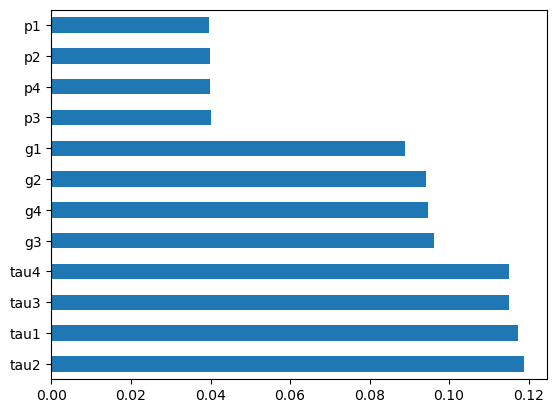

In [96]:
# feature importance using the optimal ExtraTreesClassifier model
#plot graph of feature importance
feat_importance = pd.Series(ext_clf.feature_importances_, index = X.columns)
feat_importance.nlargest(12).plot(kind='barh')
plt.show()